<a href="https://colab.research.google.com/github/dfridland/NLP/blob/HW4/DF_HW_NLP4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

что надо сделать 
1. объединить в одну выборку (это только для твитов), для роспотребнадзора сформировать датасет из вопросов
2. провести исследование и выявить тематики о которых говорят в твитах (для твитов), а для роспотребнадзора так же выявить тематики о которых люди пишут проанализировать
3. сделать визуализацию кластеров тематик
4. проинтерпритировать получившиеся тематики

In [60]:
!pip install pymorphy2
!pip install pyLDAvis==3.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136896 sha256=8c1a4d2b369a5f6bf5c510d2016818effa914e4eead6684bafe484322f081ba5
  Stored in directory: /root/.cache/pip/wheels/e9/95/74/4766157910829d2fbc6b913850a62cfd15da77a199302cdf9c
  Created wheel for sklearn: filename=sklearn-0.0.post4-py3-none-any.whl size=2973 sha256=ffa421aadfebf3c3841c35f1bd65a98480d55e451bb55b43e8f8549bfb834cb5
  Stored in directory: /root/.cache/pip/wheels/46/b8/69/4f7789b7d2fc0718a44cbc4ae5d

In [14]:
!pip install pymystem3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import pandas as pd
import numpy as np

import re

from gensim.models import *
from gensim import corpora
from nltk.corpus import stopwords
from pymystem3 import Mystem
import nltk
nltk.download('stopwords')
import pymorphy2
from tqdm.notebook import tqdm



import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import warnings

  

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
positive = pd.read_csv('sample_data/positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('sample_data/negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
data = pd.concat([positive, negative]).reset_index(drop=True)
data.tail(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,label
226824,"@ivanenko14 и у меня также, только будильник е...",negative
226825,Когда же я вернусь к тебе(( http://t.co/36qnCO...,negative
226826,"RT @qelasocadij: Скажите пожалуйста, как у чел...",negative
226827,У нас физ ра на улице\nПака линт:(\nЧерез 45 м...,negative
226828,"Нас сегодня отказались принять в сад, типа мы ...",negative
226829,Но не каждый хочет что то исправлять:( http://...,negative
226830,скучаю так :-( только @taaannyaaa вправляет мо...,negative
226831,"Вот и в школу, в говно это идти уже надо(",negative
226832,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative
226833,Такси везет меня на работу. Раздумываю приплат...,negative


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226834 entries, 0 to 226833
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    226834 non-null  object
 1   label   226834 non-null  object
dtypes: object(2)
memory usage: 3.5+ MB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Preprocessing**

In [4]:
morph = pymorphy2.MorphAnalyzer()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/usr/local/lib/python3.10/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/usr/local/lib/python3.10/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Py

In [5]:
words_regex = re.compile('\w+')

def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]


stopwords_list = stopwords.words('russian')

# mystem = Mystem()
# def lemmatize(words, lemmer = mystem, stopwords = stopwords_list):
#     lemmas = lemmer.lemmatize(' '.join(words))
#     return [w for w in lemmas if not w in stopwords 
#             and w.isalpha()]

def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords 
            and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:1: DeprecationWarning: invalid escape sequence '\w'
<>:1: DeprecationWarning: invalid escape sequence '\w'
<ipython-input-5-6d2c71807e55>:1: DeprecationWarning: invalid escape sequence '\w'
  words_regex = re.compile('\w+')


In [6]:
data.text.iloc[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'@first_timee хоть я и школота, но поверь, у нас то же самое :D общество профилирующий предмет типа)'

In [8]:
(preprocess(data.text.iloc[0]))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['школотый', 'поверь', 'самый', 'общество', 'профилировать', 'предмет', 'тип']

In [12]:
preprocessed_text = list(tqdm(map(preprocess, data['text']), total=len(data)))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/226834 [00:00<?, ?it/s]

In [13]:
data['text'] = preprocessed_text
data.sample(3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,label
192025,"[подсказывать, ранний, окончание, каникулы, пл...",negative
157201,"[газпром, впервые, история, начать, добыча, ше...",negative
109442,"[час, учить, первый, тема]",positive


**LDA Model**

In [14]:
dictionary = corpora.Dictionary(data['text'])

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # ignoring words with frequency less than 10 or taking 0.9 from dictionary
dictionary.save('tweet.dict')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
corpus = [dictionary.doc2bow(text) for text in data['text']] #vectorizing documents
corpora.MmCorpus.serialize('lenta.model', corpus) 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20, chunksize=50, update_every=1, passes=2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 3min 20s, sys: 729 ms, total: 3min 21s
Wall time: 3min 43s


**Topics** **Visualisation** 

In [18]:
%time 
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


**Estimating metrics: perpexity and** ***coherence***

In [19]:
print(lda.log_perplexity(corpus))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-26.485113177791632


In [20]:
print('Perplexity: ', np.exp(lda.log_perplexity(corpus)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Perplexity:  3.145295792799871e-12


In [22]:
coherence_model_lda = CoherenceModel(model=lda, texts=data['text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence: ', coherence_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence:  0.3034453413403495


In [25]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.060*"http" + 0.039*"это" + 0.037*"мочь" + 0.024*"знать" + 0.020*"человек" + 0.016*"большой" + 0.014*"хороший" + 0.013*"который" + 0.013*"жизнь" + 0.013*"скучать"'),
 (1,
  '0.042*"день" + 0.035*"очень" + 0.025*"это" + 0.024*"http" + 0.022*"делать" + 0.021*"любить" + 0.020*"свой" + 0.020*"сказать" + 0.020*"спать" + 0.017*"болеть"'),
 (2,
  '0.047*"весь" + 0.044*"сегодня" + 0.031*"просто" + 0.017*"год" + 0.013*"утро" + 0.012*"твой" + 0.012*"ждать" + 0.011*"посмотреть" + 0.011*"улица" + 0.010*"холодно"'),
 (3,
  '0.061*"хотеть" + 0.040*"ещё" + 0.026*"завтра" + 0.022*"это" + 0.021*"почему" + 0.017*"идти" + 0.015*"школа" + 0.015*"смотреть" + 0.014*"дом" + 0.013*"пойти"'),
 (4,
  '0.101*"всё" + 0.029*"блин" + 0.028*"вообще" + 0.020*"писать" + 0.015*"жаль" + 0.015*"хотеться" + 0.012*"понимать" + 0.012*"стать" + 0.012*"неделя" + 0.009*"пиздец"')]

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/5 [00:00<?, ?it/s]

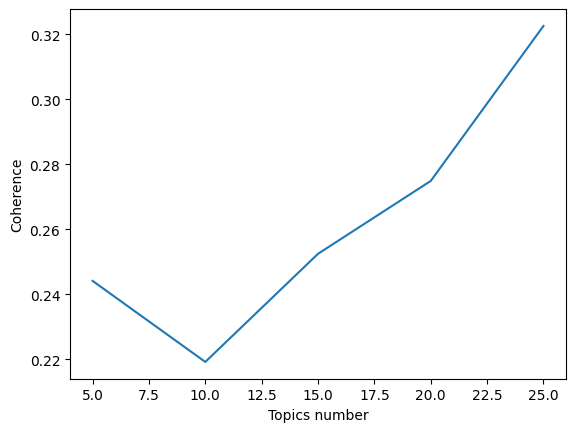

In [26]:
topics_list = [5, 10, 15, 20, 25]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=data['text'], dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Topics number")
plt.ylabel("Coherence")
plt.show()

In [27]:
lda_15 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=15, chunksize=50, update_every=1, passes=2)
vis_data = gensimvis.prepare(lda_15, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [28]:
lda.show_topics(num_topics=15, num_words=10, formatted=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(5,
  '0.354*"ещё" + 0.328*"мочь" + 0.108*"сидеть" + 0.056*"понять" + 0.040*"столько" + 0.033*"место" + 0.029*"взять" + 0.021*"жрать" + 0.010*"повод" + 0.006*"выпить"'),
 (10,
  '0.678*"хотя" + 0.132*"рассказать" + 0.000*"бояться" + 0.000*"ладный" + 0.000*"улица" + 0.000*"стоить" + 0.000*"выходить" + 0.000*"творить" + 0.000*"украинец" + 0.000*"молодец"'),
 (9,
  '0.342*"блин" + 0.233*"писать" + 0.175*"хотеться" + 0.101*"равно" + 0.068*"наверное" + 0.032*"хуйня" + 0.022*"всякий" + 0.000*"спать" + 0.000*"делать" + 0.000*"вообще"'),
 (4,
  '0.263*"просто" + 0.192*"сказать" + 0.145*"самый" + 0.086*"дело" + 0.075*"нравиться" + 0.057*"сильно" + 0.054*"гулять" + 0.024*"свет" + 0.023*"полный" + 0.017*"заметить"'),
 (2,
  '0.415*"папа" + 0.291*"фотка" + 0.102*"остальной" + 0.025*"поддержка" + 0.022*"поздний" + 0.000*"amp" + 0.000*"чёрный" + 0.000*"внизу" + 0.000*"рамка" + 0.000*"некролог"'),
 (17,
  '0.424*"думать" + 0.223*"найти" + 0.084*"серия" + 0.082*"поэтому" + 0.065*"группа" + 0.040*"веч